# Modeling Zestimate Errors
### by Jared Godar and Daniel Northcutt

## Project Goals
    
- The main goal of this project is to be able to accurately predict logerror in Zillow home price estimates.
- This will be accomplished by using data from transactions of single family homes in 2017 and clustering of data to build  models, evaluating the effectiveness of each model, and testing the best model on new data is has never seen.
- The ability to accurately value a home is essential for both buyers and sellers. The ability of us to predict error in zestimates will allow us to determine the major drivers of error then improve our home value estimation models accordingly.
- Having the most accurate estimates possible is at the core of our business.

## Wrangle
    
1. Pulled 2017 transaction data from sql server.
2. Ensure filtered for single family homes (bedroom and bathroom counts > 0, home size > 350 sq. ft.).
3. Clean function removes outliers (over $5M homes).
    5. Add county name column from `fips` data.
6. **Feature Engineering** Add columns for age of home, age bins, taxrate, size in acres, bins of acre size, sq_ft bins, structure_dollar_per_sqft,  structure_dollar_sqft_bin, land_dollar_per_sqft, lot_dollar_sqft_bin, calculate bathroom/bedroom ratio
7. Update datatypes of binned values
8. Remove outliers with invalid zipcodes
9. Scale data using linear scaler
10. Add baseline as logerror mean.
11. Create clusters for area, prize, size, and tax information (see below).
12. Give clusters real-world names.
13. Encode categorical data (clusters).
14. Split data into train, validate, test.
15. Split into X (features) and y (target) dataframes

In [58]:
##IMPORTS

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

#Modeling Tools
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import statsmodels.api as sm
from statsmodels.formula.api import ols

from datetime import date
from scipy import stats


#Custom functions
from env import host, user, password #Database credentials
import wrangle4
import env
import eval_model
import explore2
import model
## Evaluation tools
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

In [59]:
#Wrangle data as above
train, X_train, y_train, X_validate, y_validate, X_test, y_test=wrangle4.wrangle()

### Clustering

- The elbow method was employed plotting k (2-20) vs. inertia to select an appropriate k value.
- Part of wrangling. Will look at clusters in explore below.

1. **Area cluster**
   - k=6
   - Scaled_latitude, scaled_longitude, age
2. **Price Cluster**
   - k=5
   - taxrate, structure_dollar_sqft_bin, lot_dollar_sqft_bin
3. **Size Cluster**
   - k=7
   - scaled_bathroomcnt, sqft_bin, acres_bin, bath_bed_ratio

---

## Explore

### Questions


- Since we are modeling logerror, most of our questions will center on the interaction of logerror with other features.


1. What are the drivers of logerror?
2. How does logerror vary within gergraphic clusters?
3. How does logerror vary within size clusters?
4. How does logerror vary within price clusters?

---

### Question 1:

**What are the drivers of logerror?**
- Which features or categories are most strongly correlated with logerror?

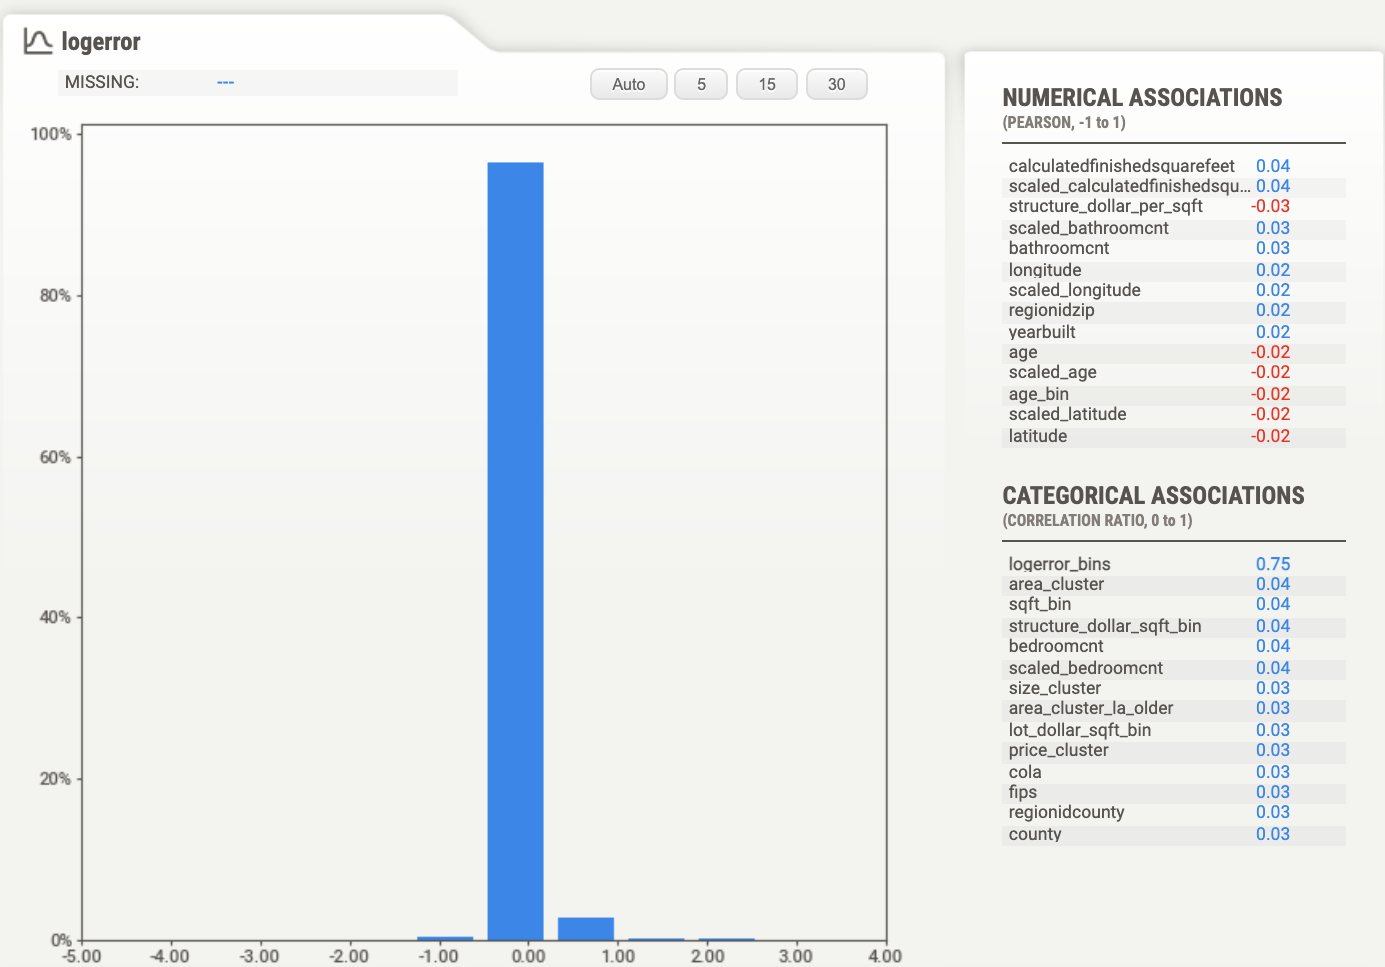

In [60]:
from IPython.display import Image
Image("logerror.png")

Note in the top right the features most strongly correlated with logerror and strongly correlated categories in the bottom right.

### Statisttcal testing

Look at pearson's R between calculatedfinishedsquarefeet and logerror

In [61]:
# Pearson R to test calculatedfinishedsquarefeet to logerror

explore2.calculatedfinishedsquarefeet_pearsonr()

 The correlation between the calculatedfinishedsquarefeet and the logerror: 0.0355
 The P value between the calculatedfinishedsquarefeet and the logerror:  1.336e-11
 
Reject null hypothesis:
 'There is no correlation between the calculatedfinishedsquarefeet and the logerror'


We now move forward with our alternative hypothesis: 
 'There is a correlation between the calculatedfinishedsquarefeet and logerror'


This is positive correlation with a low p-value.


Do the same thing looking at bins of price per area

In [62]:
# Pearson R to test structure_dollar_sqft_bin to logerror

explore2.structure_dollar_sqft_bin_pearsonr()

 The correlation between the structure_dollar_sqft_bin and the logerror: -0.0350
 The P value between the structure_dollar_sqft_bin and the logerror:  2.363e-11
 
Reject null hypothesis:
 'There is no correlation between the structure_dollar_sqft_bin and the logerror'


We now move forward with our alternative hypothesis: 
 'There is a correlation between the structure_dollar_sqft_bin and logerror'


This is a negative correlation with a low p-value.


Finally, examine the bathroomcount to logerror with pearsons r

In [63]:
# Pearson R to test scaled_bathroomcnt to logerror


explore2.scaled_bathroomcnt_pearsonr()

 The correlation between the scaled_bathroomcnt and the logerror: 0.0309
 The P value between the scaled_bathroomcnt and the logerror:  3.71e-09
 
Reject null hypothesis:
 'There is no correlation between the scaled_bathroomcnt and the logerror'


We now move forward with our alternative hypothesis: 
 'There is a correlation between the scaled_bathroomcnt and logerror'


This is positive correlation with a low p-value.


### Question 1 takeaways: 

- No columns/features had very strong correlation to the target, but many statistically significant weaker correlations were observed
- Calculatedfinishedsquarefeet, dollar_per_sqft, scaled_bathroomcount, and other columns were identified and will likely be useful features for the model
  

---

### Question 2
#### How does logerror vary within gergraphic clusters?


The following 6 geographical clusters were created using scaled lat/long and scaled age.

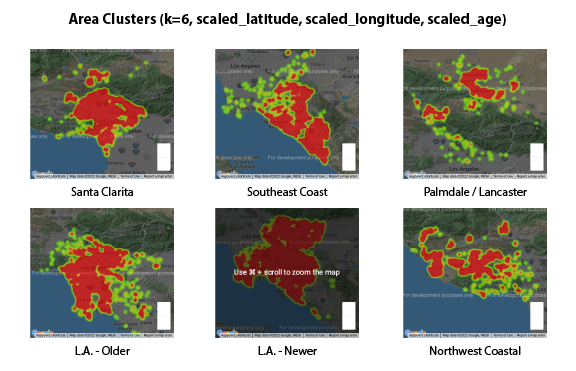

In [64]:
from IPython.display import Image
Image("area_clusters.png")

Lets look at logerror by cluster

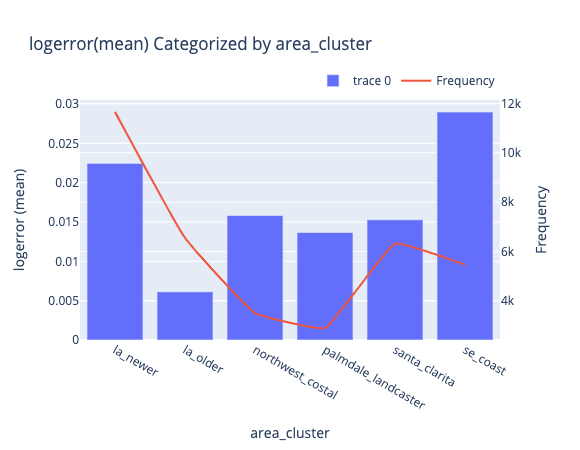

In [65]:
from IPython.display import Image
Image("area_cluster_logerror.png")

Note the logerror scale on the left and bars displaying logerror. The red trace indicates the number of houses in each cluster and that scale is on the right.

**Takeaways** We do notice differences in logerror by geocluster with la_older homes having the lowest error and newer la homes and homes on the southeast coast having higher logerror

---

### Question 3
#### How does logerror vary within size clusters?

We created size clusters using scaled_bathroomcnt', 'sqft_bin', 'acres_bin', 'bath_bed_ratio'

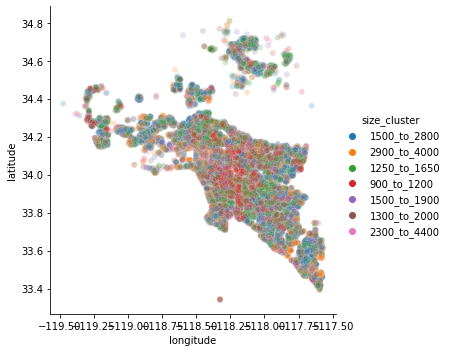

In [66]:
# Our clusters represented across the zillow dataset showing the distribution by lat/long

sns.relplot(data=X_train, x='longitude', y='latitude', alpha =0.2, hue= 'size_cluster');

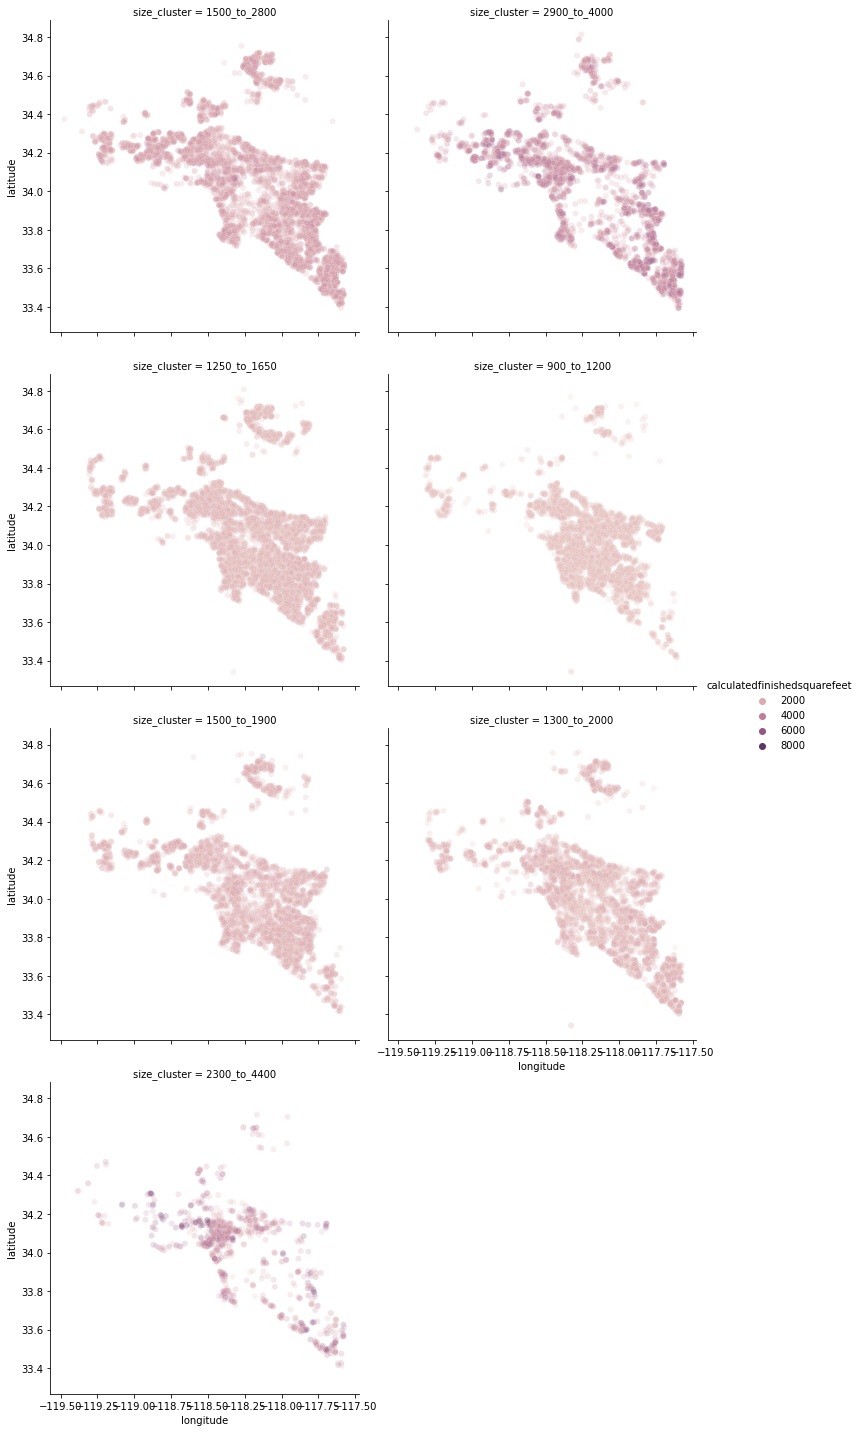

In [67]:
# Our clusters represented across the zillow dataset showing the distribution by lat/long

sns.relplot(data=X_train, x='longitude', y='latitude', hue='calculatedfinishedsquarefeet', alpha =0.2, col = 'size_cluster', col_wrap=2);

Visual representation of size clusters - all fairly well represented throughout area

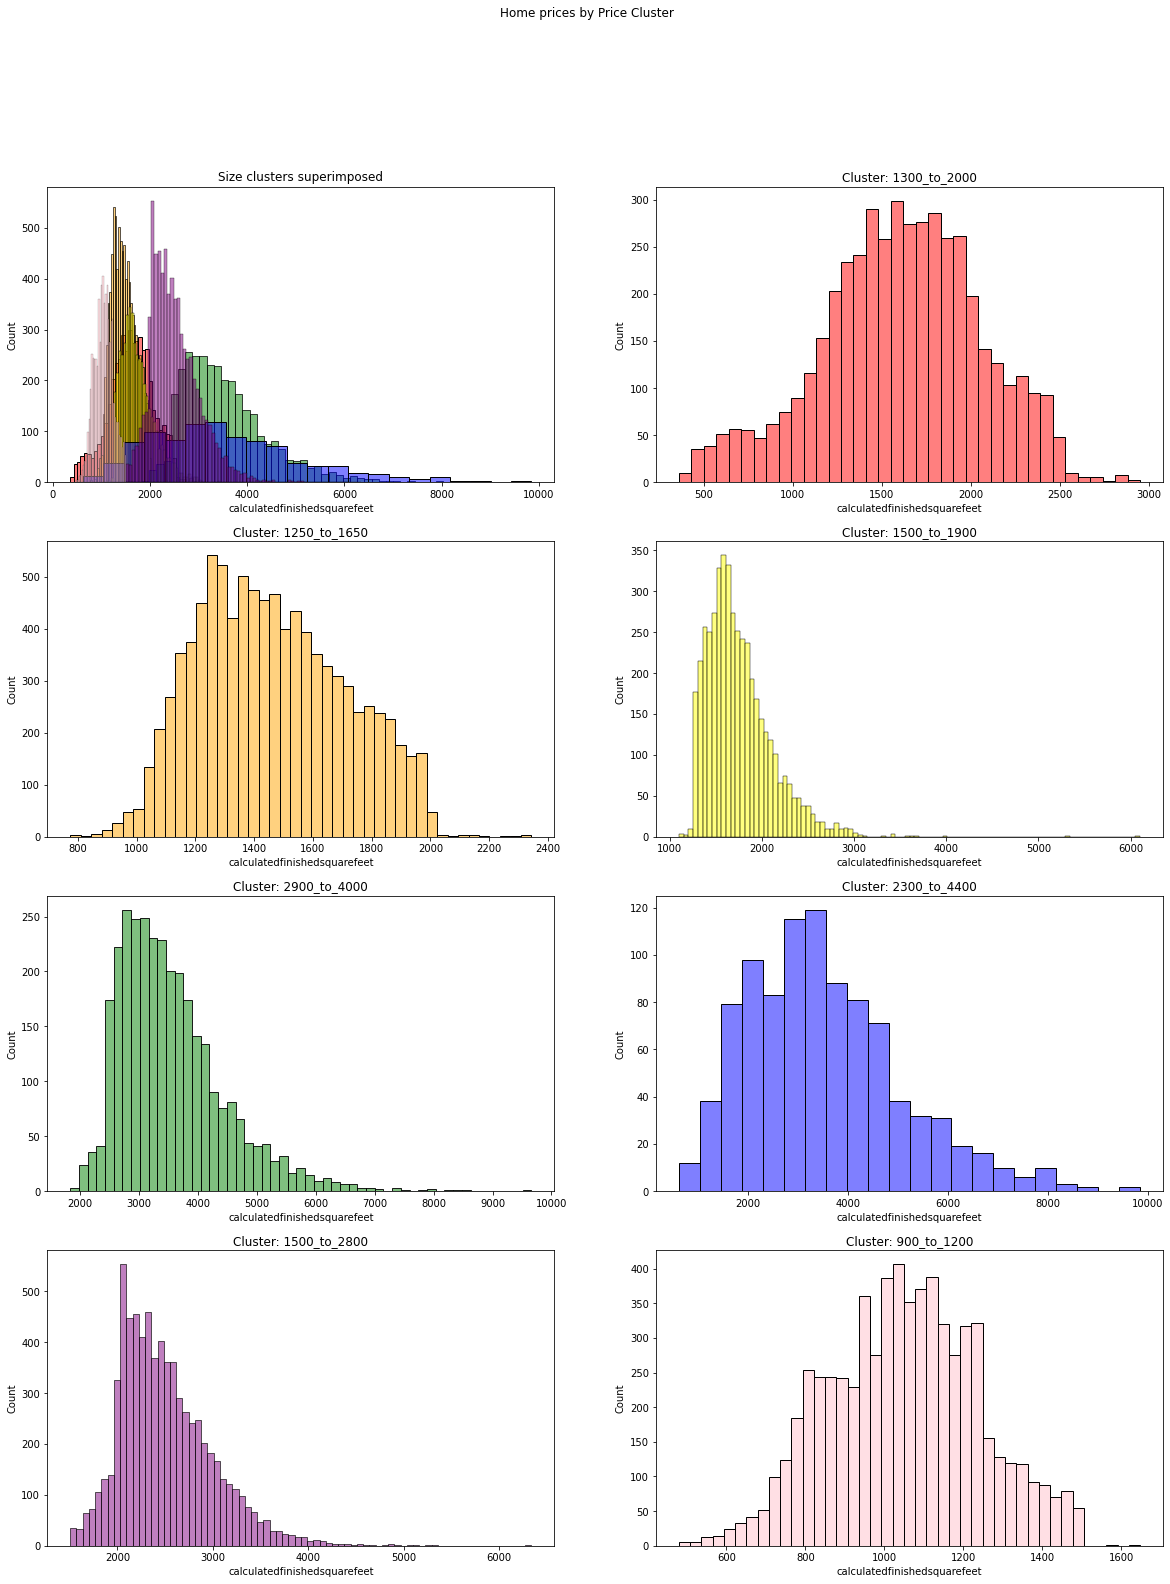

In [68]:
#Visual representation of size clustering by overlaying and looking at each cluster individually for meaning
explore2.plot_size_clusters()

Based on the size ranges observed above, we assigned names corresponding to the range of the first through third quartiles.

How does logerror vary with size clusters?

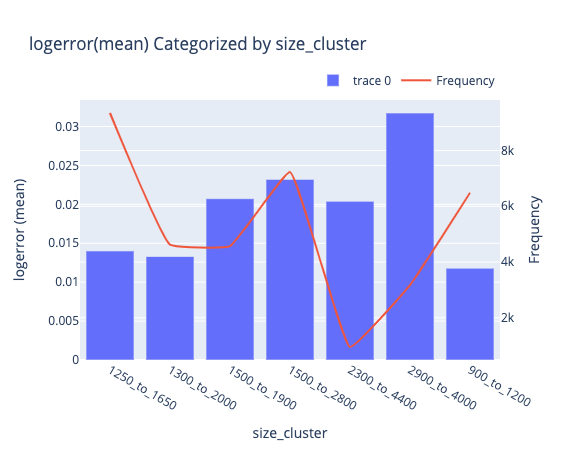

In [69]:
from IPython.display import Image
Image("size_cluster_logerror.png")

**Takeaways** lower logerror on smaller homes. Highest logerror on biggest homes.

---

### Question 4
#### How does price cluster correlate with logerror

Created clusters based on 'taxrate', 'structure_dollar_sqft_bin', 'lot_dollar_sqft_bin'

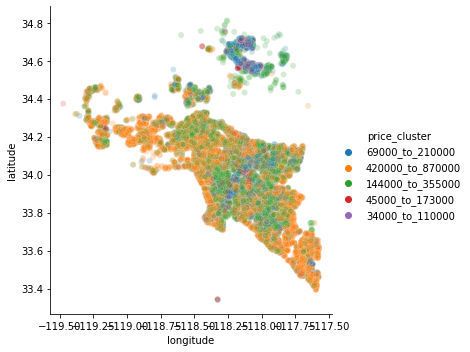

In [70]:
# Our clusters represented across the zillow dataset showing the distribution by lat/long

sns.relplot(data=X_train, x='longitude', y='latitude', alpha =0.2, hue= 'price_cluster');

Most prices distributed fairly evenly across different areas

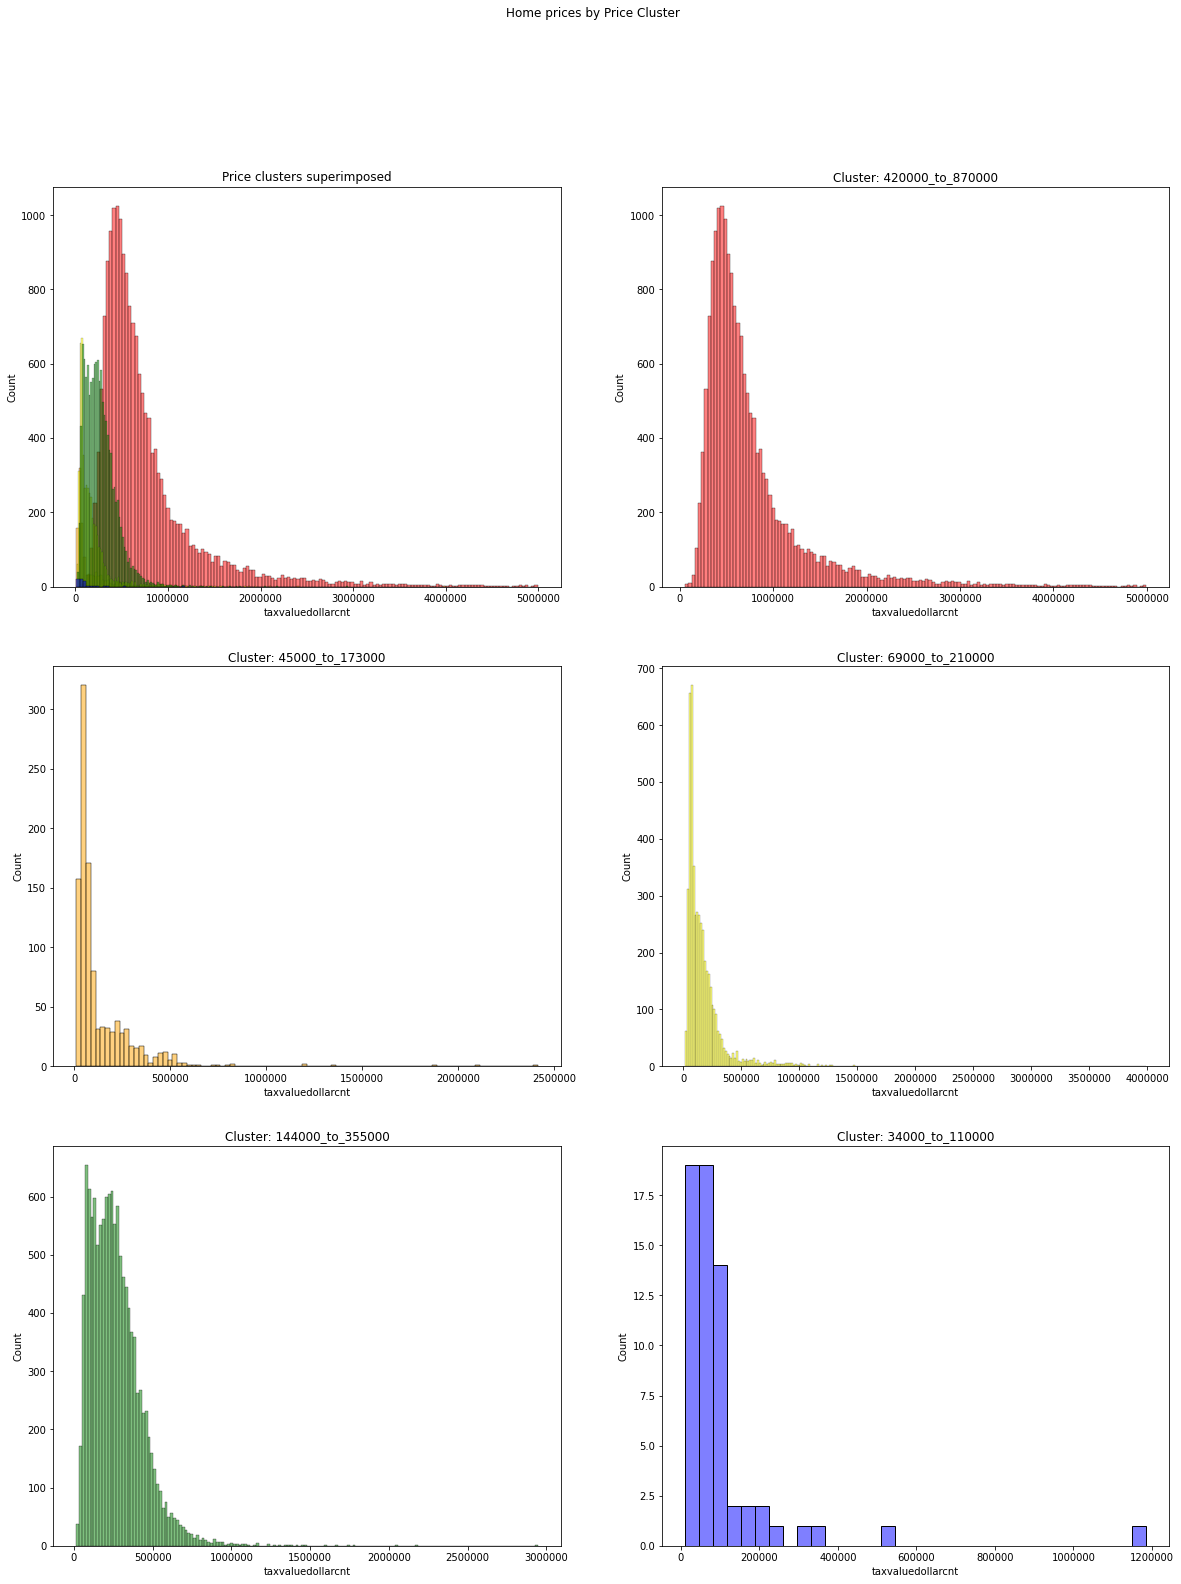

In [71]:
#Visual representation of price clustering by overlaying and looking at each cluster individually for meaning

explore2.plot_prices_clusters()

Based on the size ranges observed above, we assigned names corresponding to the range of the first through third quartiles.

How does logerror correspond to price clusters?

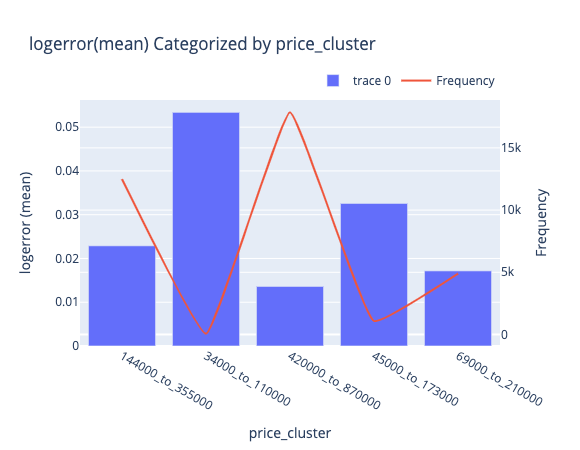

In [72]:
from IPython.display import Image
Image("price_cluster_logerror.png")

We notice lower error for less expensive homes and higher error for more expensive homes.

---

## Explore summary

- Calculatedfinishedsquarefeet, dollar_per_sqft, scaled_bathroomcount, and other columns were identified and as having statistically significant correlations with our target variable, although these correlations were fairly weak.
- We did notice differences in logerror between the assorted clusters.
  - This indicates that the cluster identity could be a useful feature for predicting error
  - Also, modeling within clusters of high error may prove fruitful.

---

## Modeling

- We created linear regression models using conbinations of our clusters as features as well as columns preciously identified as correlating with logerror.

- Root mean squared deviation is the primary benchmark for model accuracy because this tells us how close the model came the actual values.

- A summary of our models and their performance can be found in the table below.

In [29]:
model_performance =pd.read_csv('zillow_logerror_modeling.csv')
model_performance

,Model,Method,Features,train_rmse,train_r2,validate_rmse,validate_r2,train-validate_rmse,train_percent_change_rmse_baseline,validate_percent_change_rmse_baseline
0,baseline,mean,mean logerror,0.17473,0.00000,0.17015,0.00000,0.00458,NaN,NaN
1,model1,ols,"area, size, and price clusters",0.17434,0.00436,0.16988,0.00322,0.00447,-0.21812,-0.16105
2,model2,ols,"geoclusters, bathroomcnt, bedroomcnt, calculatedfinishedsquarefeet, acres, age",0.17445,0.00314,0.16995,0.00236,0.00450,-0.15729,-0.11820
3,model3,ols,"geoclusters, taxamount, taxvaluedollarcnt, structuretaxvaluedollarcnt, landtaxvaluedollarcnt, acres, age",0.17452,0.00239,0.17010,0.00061,0.00442,-0.11958,-0.03069
4,model4,ols,"taxvaluedollarcnt, structuretaxvaluedollarcnt, taxvaluedollarcnt, landtaxvaluedollarcnt, acres, age",0.17466,0.00076,0.17013,0.00020,0.00453,-0.03807,-0.01005
5,model5,ols,"geoglusters, size clusters, price clusters, taxvaluedollarcnt, structuretaxvaluedollarcnt, landtaxvaluedollarcnt, taxamount",0.17432,0.00467,0.16980,0.00411,0.00452,-0.23388,-0.20561
6,model6,ols,all clusters,0.17433,0.00447,0.16984,0.00364,0.00449,-0.22367,-0.18227


All of the models above performed better than baseline and the RMSD for validate was at least as good or better than training indicating an absence of overfitting

In [73]:
#Look at difference between model 5 train and baseline
0.17473-0.17432

0.0004099999999999937

Model 5 performed the best, beating baseline RMSE by 0.00041 representing a 0.21% improvement.

## Testing

Here we will evaluate only model 5, our best performing model, on the test dataset. This is the only time the test set has been or will be used.

In [74]:
# Set up dataframe for prediction
test_predictions = pd.DataFrame(y_test.copy())
test_predictions.rename(columns={'logerror': 'actual'}, inplace=True)

In [75]:
# Create Model
model5 = ols(formula='logerror ~ area_cluster_la_newer + area_cluster_la_older + area_cluster_northwest_costal + area_cluster_palmdale_landcaster + area_cluster_santa_clarita + area_cluster_se_coast + size_cluster_1250_to_1650 + size_cluster_1300_to_2000 + size_cluster_1500_to_1900 + size_cluster_1500_to_2800 + size_cluster_2300_to_4400 + size_cluster_2900_to_4000 + size_cluster_900_to_1200 + price_cluster_144000_to_355000 + price_cluster_34000_to_110000 + price_cluster_420000_to_870000 + price_cluster_45000_to_173000 + price_cluster_69000_to_210000 + taxvaluedollarcnt + structuretaxvaluedollarcnt  + landtaxvaluedollarcnt + taxamount', data=train).fit()

In [88]:
# Make predictions
test_predictions['model5_yhat'] = model5.predict(X_test)


In [89]:
#Calculate test RMSE and R_2
test_model5_RMSE=round((sqrt(mean_squared_error(test_predictions.actual,test_predictions.model5_yhat))), 5)
test_model5_r2 = round((r2_score(test_predictions.actual,test_predictions.model5_yhat)), 5)
baselineRMSE=0.17473
baseline_improvement=round(baselineRMSE-test_model5_RMSE, 5)
baseline_percent_change=round((test_model5_RMSE-baselineRMSE)/baselineRMSE*100, 2)

print(f'Model 5 test RMSE: {test_model5_RMSE}')
print(f'Model 5 test R2: {test_model5_r2}')
print()
print(f'Model 5 RMSE improvement from baseline: {baseline_improvement}')
print(f'Model percent improvement from baseline: {baseline_percent_change}%')

Model 5 test RMSE: 0.16957
Model 5 test R2: -0.00084

Model 5 RMSE improvement from baseline: 0.00516
Model percent improvement from baseline: -2.95%


### Model 5 test performance

Our best model obtained an RMSE of 0.16957, beating the baseline by 0.0052 or 2.95% on unseen test data.

---

## Conclusions

- By incorporating cluster data, our model improved baseline performance nearly 3%.
- Through identifying drivers of logerror, we should be able to improve models for predicting home values.

## Next Steps / Recommendations:

- The current model drops all NA values. In a subsequent iteration, thoughtful imputing of missing values will provide a richer training set which will hopefully have better outcomes.
- We would like to explore other linear regressors (LassoLars, TweedieRegressor, and Poylnomial regression tuning hyperparameters)
- Employ cross-validation techniques while tuning additional models
- Visualize residuals to see if there is systematic bias in our model or other clues for improving model.
- Use this logerror prediction data to tune and refine home price prediction models.